In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
raw_data = yf.download(tickers='EURUSD=X', start='2011-12-31', end='2019-12-31', interval='1d')
raw_data.columns = raw_data.columns.droplevel(1)
raw_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-02,1.296008,1.296008,1.296395,1.292257,1.296008,0
2012-01-03,1.294096,1.294096,1.306592,1.293628,1.293628,0
2012-01-04,1.305602,1.305602,1.307395,1.290206,1.305398,0
2012-01-05,1.293142,1.293142,1.294297,1.278527,1.293092,0
2012-01-06,1.279607,1.279607,1.281296,1.270406,1.279296,0
...,...,...,...,...,...,...
2019-12-24,1.109385,1.109385,1.109755,1.107064,1.109299,0
2019-12-25,1.109016,1.109016,1.110864,1.107788,1.109139,0
2019-12-26,1.109545,1.109545,1.110494,1.108279,1.109509,0


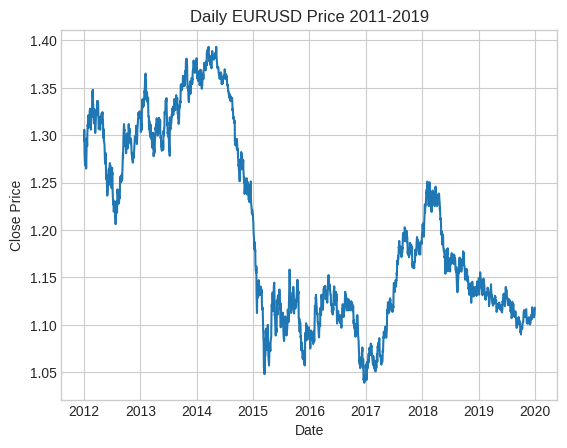

In [ ]:
plt.plot(raw_data.index, raw_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2011-2019')
plt.show()

In [ ]:
data = raw_data[['Close']]
data

Price,Close
Date,
2012-01-02,1.296008
2012-01-03,1.294096
2012-01-04,1.305602
2012-01-05,1.293142
2012-01-06,1.279607
...,...
2019-12-24,1.109385
2019-12-25,1.109016
2019-12-26,1.109545


In [ ]:
class Preprocessing:

  @staticmethod
  def data_split(data, train_size = 0.7):
    '''
    Split dataset into train_data and val_data

    Prameters:
    - data ()

    - train_size (float): The ratio of train dataset. Default is 0.7



    '''
    train_data = data[:math.ceil(len(data)*train_size)]
    val_data = data[math.ceil(len(data)*train_size):]

    return train_data, val_data

  @staticmethod
  def data_scaling(scaler, data):
    scaled_data = scaler.fit_transform(data)

    return scaled_data

  @staticmethod
  def prepare_sequence_input_label(data, window):
    X_train, y_train = [], []
    for i in range(window, len(data)):
      # X_train.append(data[i-window:i])
      # y_train.append(data[i])
      X_train.append(data[i-window:i,:])
      y_train.append(data[i,:])

    return np.array(X_train), np.array(y_train)

### Data split

In [ ]:
train_size = 0.7
train_data = data[:math.ceil(len(data)*train_size)]
val_data = data[math.ceil(len(data)*train_size):]

In [ ]:
train_data.shape, val_data.shape

((1457, 1), (624, 1))

#### Normalization with MinMaxScaler

In [ ]:
# Nomralization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
# scaled_train_data = scaler.fit_transform(train_data).reshape(-1)
# scaled_val_data = scaler.transform(val_data).reshape(-1)
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

In [ ]:
scaled_train_data.shape

(1457, 1)

In [ ]:
def prepare_sequence_input_label(data, window):
  X_train, y_train = [], []
  for i in range(window, len(data)):
    # X_train.append(data[i-window:i])
    # y_train.append(data[i])
    X_train.append(data[i-window:i,:])
    y_train.append(data[i,:])

  return np.array(X_train), np.array(y_train)

In [ ]:
window = 20 # seq_len
X_train, y_train = prepare_sequence_input_label(scaled_train_data,window)
X_val, y_val = prepare_sequence_input_label(scaled_val_data,window)

In [ ]:
X_train.shape, y_train.shape # [feature, seq_len], [feature,]

((1437, 20, 1), (1437, 1))

In [ ]:
class MyDataset(Dataset):

  def __init__(self, X, y):
    self.data = torch.tensor(X, dtype=torch.float32)
    self.true = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.true)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_true = self.true[idx]

    return out_data, out_true

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size=5, hidden_size=32, output_size=1, num_layers=1, batch_size =30):
    super().__init__()
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    output, self.hidden_cell = self.lstm(x)
    predictions = self.fc(output[:,-1,:])

    return predictions[:, 0]

In [ ]:
epochs = 30
input_size = 1
hidden_size = 30
batch_size = 1

train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# model = nn.LSTM(input_size=5, hidden_size=20, num_layers=1, batch_first=True)

model = LSTM(input_size=input_size, hidden_size= hidden_size, batch_size=batch_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss_log = []
val_loss_log = []

for epoch in range(1, epochs+1):

  # model training
  model.train()
  train_loss = 0
  for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
    X, y = data
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, y)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  # model validation
  model.eval()
  val_loss = 0
  best_val_loss = np.inf

  for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
    X_val, y_val = data
    X_val = X_val.to(device)
    y_val = y_val.to(device)


    y_val_pred = model(X_val)
    loss = criterion(y_val_pred, y_val)

    val_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  train_loss_log.append(avg_train_loss)
  avg_val_loss = val_loss / len(val_loader)
  val_loss_log.append(avg_val_loss)
  print(f'Epoch {epoch}/{epochs} loss: {avg_train_loss: .4f} Val Loss: {avg_val_loss:.4f}')

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss

    # save model
    torch.save(model.state_dict(), f'./seq2seq_{epoch}')
    print(f'Model saved with validation loss: {best_val_loss:.6f}')

  print('-'*60)

Epoch 1/30 loss:  0.0131 Val Loss: 0.0441
Model saved with validation loss: 0.044144
------------------------------------------------------------


Epoch 2/30 loss:  0.0149 Val Loss: 0.0382
Model saved with validation loss: 0.038224
------------------------------------------------------------


Epoch 3/30 loss:  0.0116 Val Loss: 0.0225
Model saved with validation loss: 0.022542
------------------------------------------------------------


Epoch 4/30 loss:  0.0062 Val Loss: 0.0157
Model saved with validation loss: 0.015737
------------------------------------------------------------


Epoch 5/30 loss:  0.0045 Val Loss: 0.0135
Model saved with validation loss: 0.013464
------------------------------------------------------------


Epoch 6/30 loss:  0.0036 Val Loss: 0.0119
Model saved with validation loss: 0.011892
------------------------------------------------------------


Epoch 7/30 loss:  0.0030 Val Loss: 0.0106
Model saved with validation loss: 0.010578
------------------------------------------------------------


Epoch 8/30 loss:  0.0026 Val Loss: 0.0070
Model saved with validation loss: 0.007020
------------------------------------------------------------


Epoch 9/30 loss:  0.0023 Val Loss: 0.0086
Model saved with validation loss: 0.008620
------------------------------------------------------------


Epoch 10/30 loss:  0.0020 Val Loss: 0.0177
Model saved with validation loss: 0.017680
------------------------------------------------------------


Epoch 11/30 loss:  0.0021 Val Loss: 0.0077
Model saved with validation loss: 0.007651
------------------------------------------------------------


Epoch 12/30 loss:  0.0019 Val Loss: 0.0115
Model saved with validation loss: 0.011494
------------------------------------------------------------


Epoch 13/30 loss:  0.0019 Val Loss: 0.0127
Model saved with validation loss: 0.012661
------------------------------------------------------------


Epoch 14/30 loss:  0.0020 Val Loss: 0.0074
Model saved with validation loss: 0.007395
------------------------------------------------------------


Epoch 15/30 loss:  0.0021 Val Loss: 0.0065
Model saved with validation loss: 0.006469
------------------------------------------------------------


Epoch 16/30 loss:  0.0018 Val Loss: 0.0106
Model saved with validation loss: 0.010630
------------------------------------------------------------


Epoch 17/30 loss:  0.0018 Val Loss: 0.0106
Model saved with validation loss: 0.010562
------------------------------------------------------------


Epoch 18/30 loss:  0.0018 Val Loss: 0.0096
Model saved with validation loss: 0.009633
------------------------------------------------------------


Epoch 19/30 loss:  0.0017 Val Loss: 0.0120
Model saved with validation loss: 0.012024
------------------------------------------------------------


Epoch 20/30 loss:  0.0017 Val Loss: 0.0120
Model saved with validation loss: 0.011951
------------------------------------------------------------


Epoch 21/30 loss:  0.0017 Val Loss: 0.0130
Model saved with validation loss: 0.013002
------------------------------------------------------------


Epoch 22/30 loss:  0.0018 Val Loss: 0.0079
Model saved with validation loss: 0.007936
------------------------------------------------------------


Epoch 23/30 loss:  0.0017 Val Loss: 0.0088
Model saved with validation loss: 0.008752
------------------------------------------------------------


Epoch 24/30 loss:  0.0017 Val Loss: 0.0093
Model saved with validation loss: 0.009334
------------------------------------------------------------


Epoch 25/30 loss:  0.0018 Val Loss: 0.0062
Model saved with validation loss: 0.006197
------------------------------------------------------------


Epoch 26/30 loss:  0.0018 Val Loss: 0.0075
Model saved with validation loss: 0.007542
------------------------------------------------------------


Epoch 27/30 loss:  0.0018 Val Loss: 0.0097
Model saved with validation loss: 0.009691
------------------------------------------------------------


Epoch 28/30 loss:  0.0018 Val Loss: 0.0181
Model saved with validation loss: 0.018057
------------------------------------------------------------


Epoch 29/30 loss:  0.0018 Val Loss: 0.0066
Model saved with validation loss: 0.006641
------------------------------------------------------------


Epoch 30/30 loss:  0.0017 Val Loss: 0.0055
Model saved with validation loss: 0.005506
------------------------------------------------------------


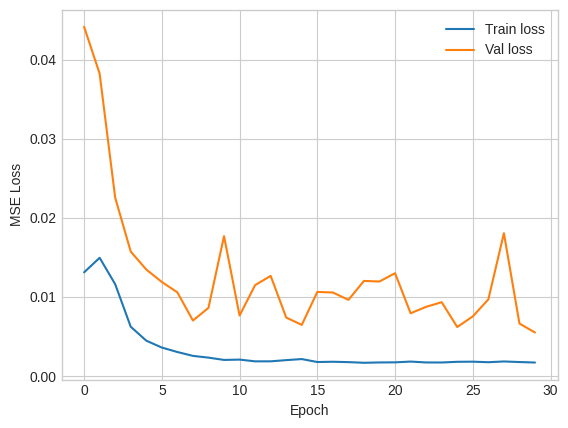

In [ ]:
plt.plot(train_loss_log, label='Train loss')
plt.plot(val_loss_log, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
epoch = 5
model.load_state_dict(torch.load(f'./seq2seq_{epoch}', map_location=torch.device(device)))

<ipython-input-237-2b825627d537>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./seq2seq_{epoch}', map_location=torch.device(device)))


<All keys matched successfully>

In [ ]:
test_data = yf.download(tickers='EURUSD=X', start='2020-01-01', end='2023-12-31', interval='1d')
test_data.columns = test_data.columns.droplevel(1)
test_data = test_data[['Close']]
test_data

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-01,1.122083
2020-01-02,1.122083
2020-01-03,1.117144
2020-01-06,1.116196
2020-01-07,1.119799
...,...
2023-12-25,1.102657
2023-12-26,1.102026
2023-12-27,1.104301


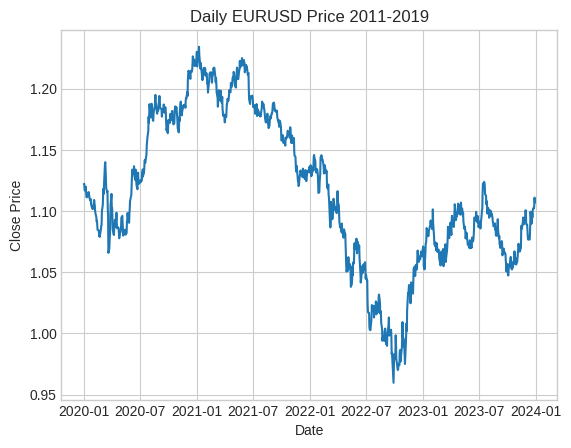

In [ ]:
plt.plot(test_data.index, test_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2020-2023')
plt.show()

In [ ]:
scaled_test_data = scaler.transform(test_data)
X_test, y_test = prepare_sequence_input_label(scaled_test_data,window)
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_data.shape

(1043, 1)

In [ ]:
# make predictions
y_pred_log = []
y_log = []

model.eval()
for batch, data in enumerate(test_loader):
  X_test, y_test = data
  X_test = X_test.to(device)
  y_test = y_test.to(device)


  y_test_pred = model(X_test)
  y_test_pred = y_test_pred.view(-1,1)
  # import pdb; pdb.set_trace()
  loss = criterion(y_test_pred, y_test)


  # invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()).item()
  y_test = scaler.inverse_transform(y_test.detach().numpy()).item()

  y_pred_log.append(y_test_pred)
  y_log.append(y_test)

In [ ]:
y_test_pred.shape, y_test.shape

In [ ]:
scaler.inverse_transform(y_test_pred.view(-1,1).detach().numpy()).item()

In [ ]:
scaler.inverse_transform(y_test.view(-1,1).detach().numpy()).item()

1.1068191528320312

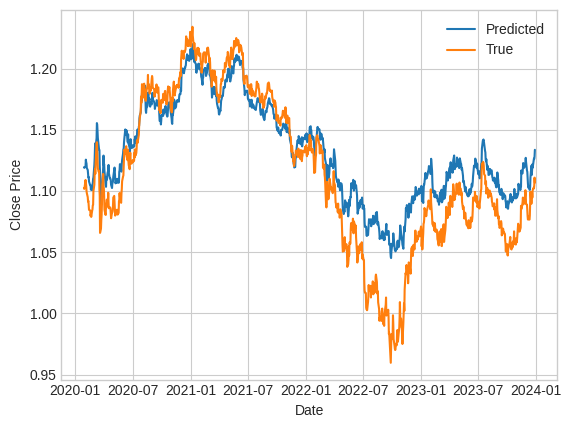

In [ ]:
plt.plot(test_data.index[window:], y_pred_log, label='Predicted')
plt.plot(test_data.index[window:], y_log, label='True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

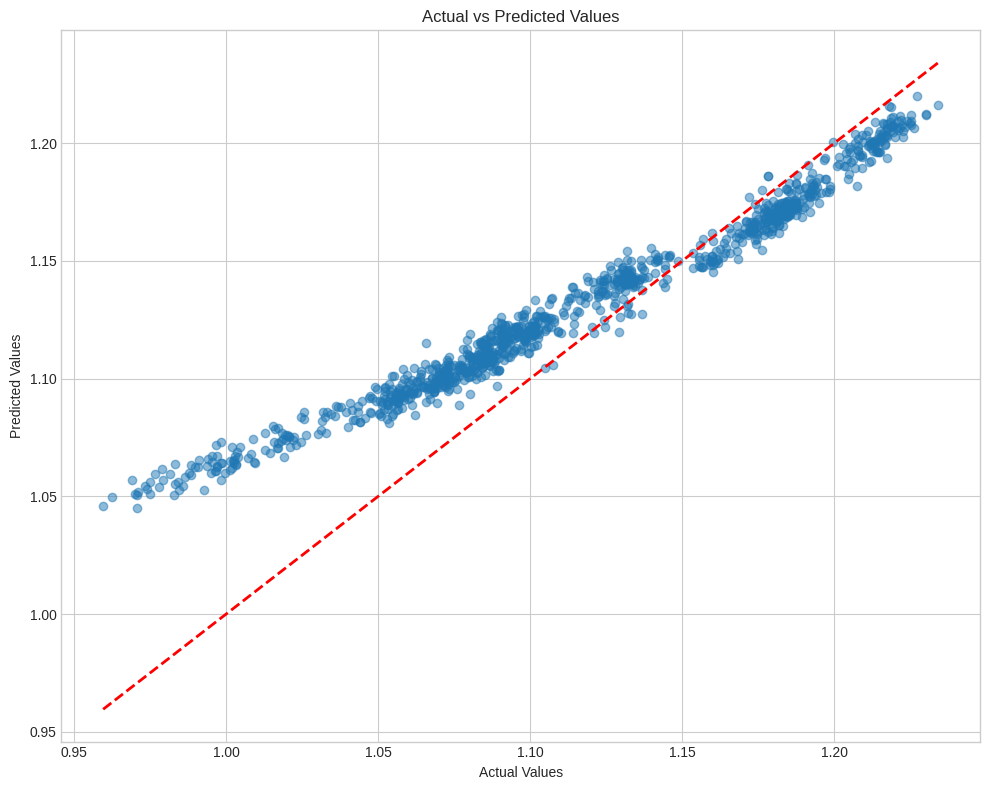

In [ ]:
# Assuming y_pred_log and y_log are your prediction and actual values
y_pred = np.array(y_pred_log)
y_actual = np.array(y_log)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()
